# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [4]:
import gym
import numpy as np

In [5]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [6]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [7]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.01391917  0.20670302  0.03509252 -0.26775593] 1 1.0 False {}
state, action, reward, done, info
[-0.00978511  0.01109828  0.02973741  0.03578562] 0 1.0 False {}
state, action, reward, done, info
[-0.00956314 -0.18443721  0.03045312  0.33770069] 0 1.0 False {}
state, action, reward, done, info
[-0.01325189  0.01023845  0.03720713  0.05477443] 1 1.0 False {}
state, action, reward, done, info
[-0.01304712 -0.1853967   0.03830262  0.35896042] 0 1.0 False {}
state, action, reward, done, info
[-0.01675505 -0.38104162  0.04548183  0.66347078] 0 1.0 False {}
state, action, reward, done, info
[-0.02437588 -0.57676582  0.05875125  0.97012052] 0 1.0 False {}
state, action, reward, done, info
[-0.0359112  -0.77262509  0.07815366  1.28066547] 0 1.0 False {}
state, action, reward, done, info
[-0.0513637  -0.96865096  0.10376696  1.59676053] 0 1.0 False {}
state, action, reward, done, info
[-0.07073672 -0.77490097  0.13570218  1.33815157] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [8]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.596760531202024 -0.9686509639926221


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size):
    # Input states/ observation or internal states
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    
    # Output actions
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [10]:
def generator(states, hidden_size, action_size, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.01 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.01 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)
        # predictions = tf.tanh(logits)

        return logits

In [11]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    actions_labels = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_labels), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return actions_logits, Qs, loss

In [12]:
class DQN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):
        
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 400               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
learning_rate = 0.001          # learning rate for training/optimization/adam

In [16]:
tf.reset_default_graph()
model = DQN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    # Episode is done/failed or not;
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, ave_raward = 0, 0
        loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from DQN
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward: {}'.format(ave_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Average rewards
            ave_raward = np.mean(rewards)
            
            # Train network
            next_actions_logits = sess.run(model.actions_logits, feed_dict={model.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/DQN-cartpole.ckpt")

Episode: 0 Total reward: 13.0 Training loss: 1.0791 Explore P: 0.9987
Episode: 1 Total reward: 17.0 Training loss: 1.6002 Explore P: 0.9970
Episode: 2 Total reward: 76.0 Training loss: 5.4402 Explore P: 0.9896
Episode: 3 Total reward: 22.0 Training loss: 6.7569 Explore P: 0.9874
Episode: 4 Total reward: 19.0 Training loss: 7.7807 Explore P: 0.9856
Episode: 5 Total reward: 13.0 Training loss: 113.3744 Explore P: 0.9843
Episode: 6 Total reward: 18.0 Training loss: 8.3175 Explore P: 0.9825
Episode: 7 Total reward: 13.0 Training loss: 5.4326 Explore P: 0.9813
Episode: 8 Total reward: 14.0 Training loss: 4.6847 Explore P: 0.9799
Episode: 9 Total reward: 15.0 Training loss: 107.5247 Explore P: 0.9785
Episode: 10 Total reward: 10.0 Training loss: 53.6882 Explore P: 0.9775
Episode: 11 Total reward: 20.0 Training loss: 5.0291 Explore P: 0.9756
Episode: 12 Total reward: 13.0 Training loss: 68.2973 Explore P: 0.9743
Episode: 13 Total reward: 7.0 Training loss: 111.6712 Explore P: 0.9736
Episode: 

Episode: 114 Total reward: 102.0 Training loss: 14.2473 Explore P: 0.7351
Episode: 115 Total reward: 13.0 Training loss: 12.2859 Explore P: 0.7342
Episode: 116 Total reward: 92.0 Training loss: 106.9656 Explore P: 0.7275
Episode: 117 Total reward: 31.0 Training loss: 229.8247 Explore P: 0.7253
Episode: 118 Total reward: 22.0 Training loss: 120.4688 Explore P: 0.7237
Episode: 119 Total reward: 21.0 Training loss: 49.0741 Explore P: 0.7222
Episode: 120 Total reward: 11.0 Training loss: 20.4032 Explore P: 0.7214
Episode: 121 Total reward: 62.0 Training loss: 167.0723 Explore P: 0.7171
Episode: 122 Total reward: 18.0 Training loss: 26.9125 Explore P: 0.7158
Episode: 123 Total reward: 83.0 Training loss: 58.3354 Explore P: 0.7099
Episode: 124 Total reward: 44.0 Training loss: 26.8100 Explore P: 0.7069
Episode: 125 Total reward: 68.0 Training loss: 47.6061 Explore P: 0.7022
Episode: 126 Total reward: 36.0 Training loss: 54.2426 Explore P: 0.6997
Episode: 127 Total reward: 145.0 Training loss

Episode: 224 Total reward: 199.0 Training loss: 29.9727 Explore P: 0.1818
Episode: 225 Total reward: 199.0 Training loss: 30.2138 Explore P: 0.1784
Episode: 226 Total reward: 199.0 Training loss: 16.9184 Explore P: 0.1751
Episode: 227 Total reward: 199.0 Training loss: 23.3373 Explore P: 0.1719
Episode: 228 Total reward: 199.0 Training loss: 13.1757 Explore P: 0.1687
Episode: 229 Total reward: 199.0 Training loss: 13.4147 Explore P: 0.1656
Episode: 230 Total reward: 199.0 Training loss: 31.2860 Explore P: 0.1625
Episode: 231 Total reward: 199.0 Training loss: 18.6120 Explore P: 0.1595
Episode: 232 Total reward: 199.0 Training loss: 6.0755 Explore P: 0.1565
Episode: 233 Total reward: 199.0 Training loss: 148.5719 Explore P: 0.1537
Episode: 234 Total reward: 199.0 Training loss: 16.3648 Explore P: 0.1508
Episode: 235 Total reward: 199.0 Training loss: 8.8119 Explore P: 0.1480
Episode: 236 Total reward: 199.0 Training loss: 5.7813 Explore P: 0.1453
Episode: 237 Total reward: 199.0 Trainin

Episode: 336 Total reward: 199.0 Training loss: 0.5086 Explore P: 0.0288
Episode: 337 Total reward: 199.0 Training loss: 1.1782 Explore P: 0.0284
Episode: 338 Total reward: 199.0 Training loss: 0.9654 Explore P: 0.0281
Episode: 339 Total reward: 199.0 Training loss: 1.4784 Explore P: 0.0277
Episode: 340 Total reward: 168.0 Training loss: 2.1882 Explore P: 0.0274
Episode: 341 Total reward: 199.0 Training loss: 1.3349 Explore P: 0.0271
Episode: 342 Total reward: 199.0 Training loss: 0.9309 Explore P: 0.0268
Episode: 343 Total reward: 199.0 Training loss: 0.5759 Explore P: 0.0264
Episode: 344 Total reward: 199.0 Training loss: 1.0344 Explore P: 0.0261
Episode: 345 Total reward: 180.0 Training loss: 0.5408 Explore P: 0.0258
Episode: 346 Total reward: 199.0 Training loss: 1.1164 Explore P: 0.0255
Episode: 347 Total reward: 199.0 Training loss: 1.1233 Explore P: 0.0252
Episode: 348 Total reward: 199.0 Training loss: 1.9525 Explore P: 0.0249
Episode: 349 Total reward: 199.0 Training loss: 0.5

Episode: 448 Total reward: 10.0 Training loss: 365.7355 Explore P: 0.0123
Episode: 449 Total reward: 11.0 Training loss: 242.7701 Explore P: 0.0123
Episode: 450 Total reward: 11.0 Training loss: 227.0681 Explore P: 0.0123
Episode: 451 Total reward: 7.0 Training loss: 155.4974 Explore P: 0.0123
Episode: 452 Total reward: 10.0 Training loss: 241.1767 Explore P: 0.0123
Episode: 453 Total reward: 11.0 Training loss: 212.1013 Explore P: 0.0123
Episode: 454 Total reward: 10.0 Training loss: 272.4958 Explore P: 0.0123
Episode: 455 Total reward: 9.0 Training loss: 990.9998 Explore P: 0.0123
Episode: 456 Total reward: 9.0 Training loss: 1315.6061 Explore P: 0.0123
Episode: 457 Total reward: 10.0 Training loss: 946.5555 Explore P: 0.0123
Episode: 458 Total reward: 10.0 Training loss: 937.7999 Explore P: 0.0123
Episode: 459 Total reward: 11.0 Training loss: 870.1475 Explore P: 0.0123
Episode: 460 Total reward: 8.0 Training loss: 1203.0531 Explore P: 0.0123
Episode: 461 Total reward: 11.0 Training

Episode: 560 Total reward: 55.0 Training loss: 1.0995 Explore P: 0.0106
Episode: 561 Total reward: 199.0 Training loss: 1.8211 Explore P: 0.0106
Episode: 562 Total reward: 199.0 Training loss: 1.5094 Explore P: 0.0106
Episode: 563 Total reward: 90.0 Training loss: 1.6035 Explore P: 0.0106
Episode: 564 Total reward: 199.0 Training loss: 5.6514 Explore P: 0.0106
Episode: 565 Total reward: 199.0 Training loss: 20.7888 Explore P: 0.0106
Episode: 566 Total reward: 199.0 Training loss: 1.4395 Explore P: 0.0106
Episode: 567 Total reward: 199.0 Training loss: 2.9732 Explore P: 0.0105
Episode: 568 Total reward: 199.0 Training loss: 1.0725 Explore P: 0.0105
Episode: 569 Total reward: 199.0 Training loss: 58.1974 Explore P: 0.0105
Episode: 570 Total reward: 167.0 Training loss: 3.6979 Explore P: 0.0105
Episode: 571 Total reward: 199.0 Training loss: 36.0830 Explore P: 0.0105
Episode: 572 Total reward: 199.0 Training loss: 61.8252 Explore P: 0.0105
Episode: 573 Total reward: 199.0 Training loss: 2

Episode: 674 Total reward: 12.0 Training loss: 3507.5581 Explore P: 0.0102
Episode: 675 Total reward: 30.0 Training loss: 2156943.5000 Explore P: 0.0102
Episode: 676 Total reward: 10.0 Training loss: 4157.5796 Explore P: 0.0102
Episode: 677 Total reward: 8.0 Training loss: 4475.3452 Explore P: 0.0102
Episode: 678 Total reward: 11.0 Training loss: 996294.1250 Explore P: 0.0102
Episode: 679 Total reward: 10.0 Training loss: 3010948.5000 Explore P: 0.0102
Episode: 680 Total reward: 11.0 Training loss: 3709.3413 Explore P: 0.0102
Episode: 681 Total reward: 12.0 Training loss: 1494.8245 Explore P: 0.0102
Episode: 682 Total reward: 11.0 Training loss: 2354.1636 Explore P: 0.0102
Episode: 683 Total reward: 9.0 Training loss: 2718.6392 Explore P: 0.0102
Episode: 684 Total reward: 9.0 Training loss: 1973.5162 Explore P: 0.0102
Episode: 685 Total reward: 8.0 Training loss: 3519.7012 Explore P: 0.0102
Episode: 686 Total reward: 7.0 Training loss: 2942.9109 Explore P: 0.0102
Episode: 687 Total rew

Episode: 784 Total reward: 159.0 Training loss: 172.0371 Explore P: 0.0101
Episode: 785 Total reward: 199.0 Training loss: 60.4378 Explore P: 0.0101
Episode: 786 Total reward: 198.0 Training loss: 52.2433 Explore P: 0.0101
Episode: 787 Total reward: 190.0 Training loss: 66.2770 Explore P: 0.0101
Episode: 788 Total reward: 162.0 Training loss: 477.8328 Explore P: 0.0101
Episode: 789 Total reward: 199.0 Training loss: 49.4377 Explore P: 0.0101
Episode: 790 Total reward: 135.0 Training loss: 56.2411 Explore P: 0.0101
Episode: 791 Total reward: 198.0 Training loss: 29.8293 Explore P: 0.0101
Episode: 792 Total reward: 148.0 Training loss: 32.6934 Explore P: 0.0101
Episode: 793 Total reward: 193.0 Training loss: 128.8837 Explore P: 0.0101
Episode: 794 Total reward: 192.0 Training loss: 14.0071 Explore P: 0.0101
Episode: 795 Total reward: 95.0 Training loss: 39.0817 Explore P: 0.0101
Episode: 796 Total reward: 195.0 Training loss: 39.3315 Explore P: 0.0101
Episode: 797 Total reward: 175.0 Tra

Episode: 894 Total reward: 182.0 Training loss: 281.3439 Explore P: 0.0100
Episode: 895 Total reward: 199.0 Training loss: 118.5391 Explore P: 0.0100
Episode: 896 Total reward: 199.0 Training loss: 83.0166 Explore P: 0.0100
Episode: 897 Total reward: 199.0 Training loss: 191.1038 Explore P: 0.0100
Episode: 898 Total reward: 164.0 Training loss: 118.2242 Explore P: 0.0100
Episode: 899 Total reward: 157.0 Training loss: 53.3982 Explore P: 0.0100
Episode: 900 Total reward: 199.0 Training loss: 53.8570 Explore P: 0.0100
Episode: 901 Total reward: 168.0 Training loss: 85.0355 Explore P: 0.0100
Episode: 902 Total reward: 161.0 Training loss: 99.1256 Explore P: 0.0100
Episode: 903 Total reward: 144.0 Training loss: 80.8761 Explore P: 0.0100
Episode: 904 Total reward: 157.0 Training loss: 120.0307 Explore P: 0.0100
Episode: 905 Total reward: 199.0 Training loss: 52.4007 Explore P: 0.0100
Episode: 906 Total reward: 160.0 Training loss: 71.0915 Explore P: 0.0100
Episode: 907 Total reward: 199.0 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

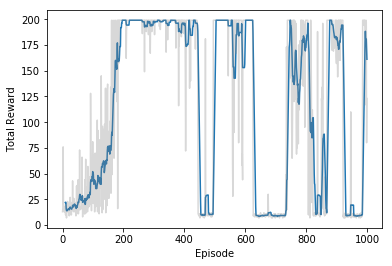

In [20]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0,0.5,'Training Loss')

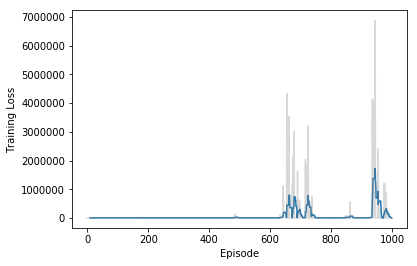

In [21]:
eps, loss = np.array(loss_list).T
smoothed_loss = running_mean(loss, 10)
plt.plot(eps[-len(smoothed_loss):], smoothed_loss)
plt.plot(eps, loss, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Training Loss')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 10
test_max_steps = 10000000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Restore/load the trained model 
    saver.restore(sess, "checkpoints/DQN-cartpole.ckpt")
    
    # Training episodes/ epochs
    for ep in range(test_episodes):
        
        # Env/Rob steps for minibatches/batches training
        t = 0
        while t < test_max_steps:
            
            # render the graphics
            env.render() 
            
            # Get action from DQN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # If episode is done/failed;
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

# Closing the simulated env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/DQN-cartpole.ckpt


ArgumentError: argument 2: <class 'TypeError'>: wrong type

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.